In [8]:
import zarr
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
#load dataset
dataset_path = "gs://weatherbench2/datasets/hres_t0/2016-2022-6h-512x256_equiangular_conservative.zarr"
ds = xr.open_zarr(dataset_path, consolidated=True)
print(ds)

<xarray.Dataset> Size: 526GB
Dimensions:                  (time: 10228, longitude: 512, latitude: 256,
                              level: 13)
Coordinates:
  * latitude                 (latitude) float64 2kB -89.65 -88.95 ... 89.65
  * level                    (level) int32 52B 50 100 150 200 ... 850 925 1000
  * longitude                (longitude) float64 4kB 0.0 0.7031 ... 358.6 359.3
  * time                     (time) datetime64[ns] 82kB 2016-01-01 ... 2022-1...
Data variables: (12/14)
    10m_u_component_of_wind  (time, longitude, latitude) float32 5GB ...
    10m_v_component_of_wind  (time, longitude, latitude) float32 5GB ...
    10m_wind_speed           (time, longitude, latitude) float32 5GB ...
    2m_temperature           (time, longitude, latitude) float32 5GB ...
    geopotential             (time, level, longitude, latitude) float32 70GB ...
    mean_sea_level_pressure  (time, longitude, latitude) float32 5GB ...
    ...                       ...
    temperature        

### Visualise the Data

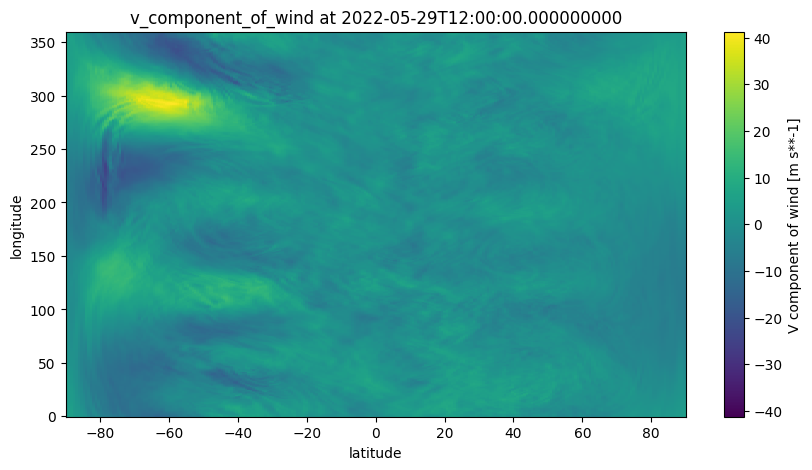

In [40]:
random_time = np.random.choice(ds.time)
random_var = np.random.choice(list(ds.data_vars))

frame = ds[random_var].sel(time=random_time)

if frame.ndim == 3:
    frame = frame.isel(level=0)

plt.figure(figsize=(10, 5))
frame.plot.pcolormesh(cmap="viridis")
plt.title(f"{random_var} at {str(random_time)}")
plt.show()

# Building the model

### 1. Embeddings

We will define a Patch Embedding class that splits the input frame into smaller patches and linearly project them into higher-dimensional space. Here we will use 2D convolution to achieve this objective. This is necessary since we are implementing a Vision Transformer architecture. We will also include a positional embedding for positional information to these smaller patches. 

We also need to incorporate `lead_time` into the model, here we will add it as an additional token, that will be embed into a vector of the same dimension as the patch embeddings.

In [62]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=(512, 256), patch_size=(16, 16), in_channels=1, embed_dim=768, dropout=0.1):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels = in_channels,
                out_channels = embed_dim,
                kernel_size = patch_size,
                stride = patch_size
            ),
            nn.Flatten(2, 3)
        )
        self.num_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
        self.cls_token = nn.Parameter(torch.randn(size=(1, 1, embed_dim)), requires_grad=True)
        self.lead_time_embedding = nn.Linear(1, embed_dim)
        self.positional_embeddings = nn.Parameter(torch.randn(size=(1, self.num_patches + 2, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x, lead_time):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        lead_time_embed = self.lead_time_embedding(lead_time.unsqueeze(-1))
        lead_time_embed = lead_time_embed.unsqueeze(1)
        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, lead_time_embed, x], dim=1)
        x = self.positional_embeddings + x
        x = self.dropout(x)
        return x


### 2. ViT Model

The key components of my implementation is that we first use the Patch Embedding block, the the PyTorch's built-in Transformer Encoder for simplicity and efficiency and finally the MLP head that takes the `cls_token` and applies a layer normalization followed by linear layer.

In [57]:
class ViT_PyTorch(nn.Module):
    def __init__(self, img_size=(256, 512), patch_size=(16, 16), in_channels=1, embed_dim=768, dropout=0.1, num_heads=8, num_encoders=6, expansion=4):
        super().__init__()
        self.embeddings_block = PatchEmbedding(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=embed_dim,
            dropout=dropout
        )
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dropout=dropout,
            dim_feedforward=int(embed_dim * expansion),
            activation="gelu",
            batch_first=True,
            norm_first=True
        )
        self.encoder_block = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=patch_size[0] * patch_size[1] * in_channels),
            nn.Unflatten(dim=1, unflattened_size=(in_channels, patch_size[0], patch_size[1]))
        )

    def forward(self, x, lead_time):
        x = self.embeddings_block(x, lead_time)
        x = self.encoder_block(x)
        x = self.mlp_head(x[:, 0])  # Use the cls_token for prediction
        return x

In [ ]:
batch_size = 8
in_channels = 1
height = 256
width = 512
patch_size = (16, 16)
lead_time = torch.rand(batch_size)

x = torch.rand(batch_size, in_channels, height, width)

print("Input shape:", x.shape)
print("Lead time shape:", lead_time.shape)

embed_dim = 768
dropout = 0.1
num_heads = 8
num_encoders = 6
expansion = 4

model = ViT_PyTorch(
    img_size=(height, width),
    patch_size=patch_size,
    in_channels=in_channels,
    embed_dim=embed_dim,
    dropout=dropout,
    num_heads=num_heads,
    num_encoders=num_encoders,
    expansion=expansion
)

output = model(x, lead_time)

print("Output shape:", output.shape)

Input shape: torch.Size([8, 1, 256, 512])
Lead time shape: torch.Size([8])
ViT_PyTorch(
  (embeddings_block): PatchEmbedding(
    (patcher): Sequential(
      (0): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
      (1): Flatten(start_dim=2, end_dim=3)
    )
    (lead_time_embedding): Linear(in_features=1, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_block): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dr

c:\Users\stagr\Desktop\Code\Silurian\venv\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Output shape: torch.Size([8, 1, 16, 16])


### What part of the architecture uses the most memory ?

In [61]:
from torchinfo import summary

batch_size = 8
in_channels = 1
height = 256
width = 512

# Create dummy inputs
x = torch.randn(batch_size, in_channels, height, width)
lead_time = torch.randn(batch_size)

summary(model, input_data=[x, lead_time], device="cpu") #don't have GPU sorry

Layer (type:depth-idx)                        Output Shape              Param #
ViT_PyTorch                                   [8, 1, 16, 16]            --
├─PatchEmbedding: 1-1                         [8, 514, 768]             395,520
│    └─Linear: 2-1                            [8, 768]                  1,536
│    └─Sequential: 2-2                        [8, 768, 512]             --
│    │    └─Conv2d: 3-1                       [8, 768, 16, 32]          197,376
│    │    └─Flatten: 3-2                      [8, 768, 512]             --
│    └─Dropout: 2-3                           [8, 514, 768]             --
├─TransformerEncoder: 1-2                     [8, 514, 768]             --
│    └─ModuleList: 2-4                        --                        --
│    │    └─TransformerEncoderLayer: 3-3      [8, 514, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [8, 514, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [8, 514, 768]         

It seems like the Transformer Encoder layer is the most memory-intensive part of the architecture (accounts for ~98% of the parameters). I used `torchinfo` to analyze the memory usage, as it clearly breaks down the memory consumption summary for each component of the architecture.

### Scaling the architecture to handle high-resolution datasets

Handling higher resolutions requires more memory during both forward and backward passes, we also need more compute power and the number of patches will increase, thus we get longer sequences and again larger memory requirements.

The self-attention mechanism in the transformer encoder that we used has complexity $O(n^2)$ where $n$ is the sequency length. For an input resolution of 512x256, here we tested patch size of 16x16, thus we have 512 patches. But for an input resolution of 3600x1800 with the same patch size we have 25312 patches.

After some research, I have found that there a few techniques to scale the architecture to higher resolutions:
- We can use progressive patch embedding where we start with larger patches and gradually reduce their size, thus reducing the sequence length. Good if our systems are memory constrained but might not have the best precision.
- We can use sparse attention instead of standard self-attention, reducing complexity to $O(n \log{n})$. Actually very good for high resolutions but tends to ignore long-range dependencies.
- Or we can do distributed training, if we have the hardware available but it is a financially costly solution.

### Adding more pressure levels.

Our data variables have 13 pressure levels each corresponding to a specific altitude in the atmosphere. Thus adding more levels will increase input dimensionality & memory usage & compute requirements. The model might need to learn more complex relationships between pressure levels.

We could project the pressure levels into lower-dimensional subspaces to reduce the memory usage and computational complexity or even do 1D convolutions along pressure level dimension to extract features with more efficiency.

### Activation checkpointing at high resolutions.

From the `torchinfo` summary, we know that the TransformerEncoderLayer dominates the memory consumption, thus it will be the primary bottleneck. Activation checkpointing at higher resolutions reduces memory usage but increases computation time due to self-attention's quadratic scaling (checkpointing forces recomputation). Combining checkpointing with sparse attention would be a good mitigation strategy here.

### Performing all computations using `bf16`

This gives us a wider dynamic range less prone to overflow AND underflow but we have lower precision for small values. This is ideal for large-scale models like transformers. Let's see for each key component of the architecture if we can perform computations using `bf16`:
- Pach Embedding uses convolutions and linear projections thus we can safely use it.
- Transformer Encoder's self-attention mechanisme uses softwax requires stable precision thus it might not be optimal here.
- MLP head yes
- Layer normalization yes but we need stability thus maybe use `fp32`.

### Normalizing the input data

It is important to consider normalizing the input data, as we have variables with different units, different scales and physical meaning in their ranges, thus this would help us have stable training, faster convergence and meaningful feature mixing. 

For weather data, we can use per-variable standardization, we normalize separately per pressure-level and we bounded variables such as precipitation using min-max scaling.

In [ ]:
#found mock code online
stats = {
    "2m_temperature": {"mean": 280.0, "std": 10.0},
    "geopotential": {"mean": torch.tensor([...]), "std": torch.tensor([...])},  # Per-level
}

def normalize_input(x, variable):
    return (x - stats[variable]["mean"]) / stats[variable]["std"]

### Training, finetuning & inference

For training, I would implement checkpointing with gradient checkpointing in the transformer layers and I would enable mixed precision `bf16` &  `fp16`. This would reduce the amount of memory required.

For finetuning, I think using LoRA here would be an effective technique to limit trainable parameters by a great amount.

For Inference, fuse the kernels with `torch.compile()` for better memory management efficiency, I would also cache attention for sequential predictions and quantize to INT8/FP8 which would mean smaller models.